In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import datetime
import gurobipy as gp
from gurobipy import GRB
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
def dateTimeList(start,end):
    result=[start]
    while(start < end) :
        start += datetime.timedelta(minutes=15)
        result.append(start)
    return result

# Solar

In [3]:
dfSolar = pd.read_csv(r"C:\Users\Janwe\OneDrive\Desktop\Bachelor_Arbeit\Direct Load Control Model\Data\Solar_2019.csv")

In [4]:
start = datetime.datetime(2019,1,1,0,15,0)
end = datetime.datetime(2020,1,1,0,0,0)

dfSolar["date"] = dateTimeList(start,end)
dfSolar = dfSolar[["date","Ist-Wert (MW)","Prognose (MW)"]]
dfSolar.head()

,date,Ist-Wert (MW),Prognose (MW)
0,2019-01-01 00:15:00,0,0
1,2019-01-01 00:30:00,0,0
2,2019-01-01 00:45:00,0,0
3,2019-01-01 01:00:00,0,0
4,2019-01-01 01:15:00,0,0


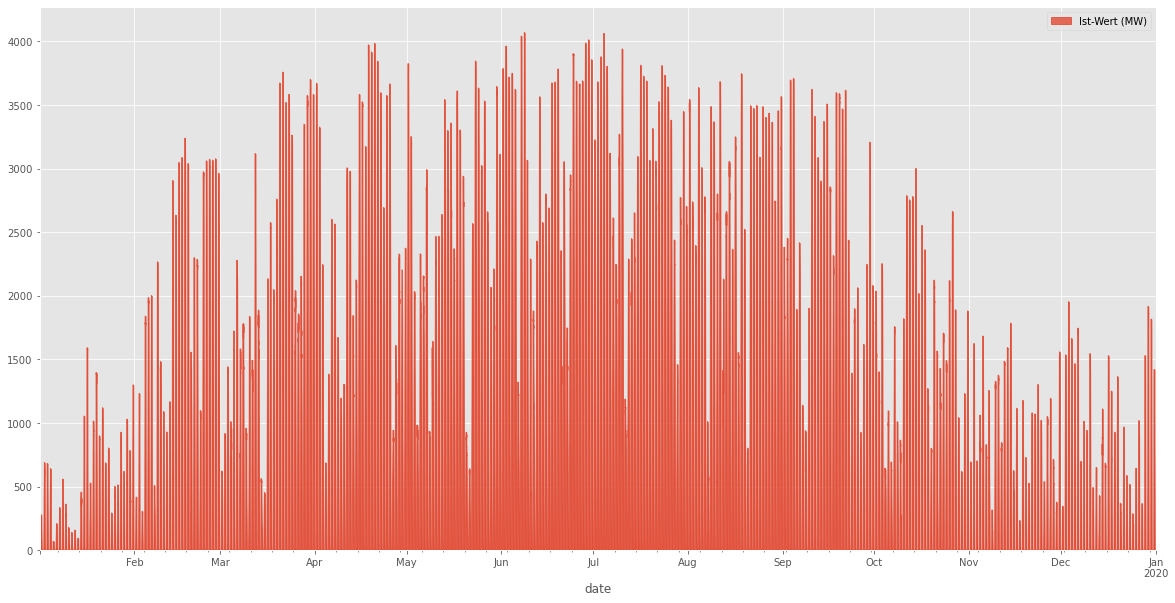

In [5]:
dfSolar.plot.area(x="date",y="Ist-Wert (MW)",figsize=(20,10),lw=1,alpha=0.8)

# Wind

In [6]:
dfWind = pd.read_csv(r"C:\Users\Janwe\OneDrive\Desktop\Bachelor_Arbeit\Direct Load Control Model\Data\Wind_2019.csv")

In [7]:
start = datetime.datetime(2019,1,1,0,15,0)
end = datetime.datetime(2020,1,1,0,0,0)
dfWind["date"] = dateTimeList(start,end)
dfWind = dfWind[["date","Ist-Wert (MW)","Prognose (MW)"]]
dfWind.head()

,date,Ist-Wert (MW),Prognose (MW)
0,2019-01-01 00:15:00,88,97
1,2019-01-01 00:30:00,94,100
2,2019-01-01 00:45:00,96,102
3,2019-01-01 01:00:00,98,105
4,2019-01-01 01:15:00,104,109


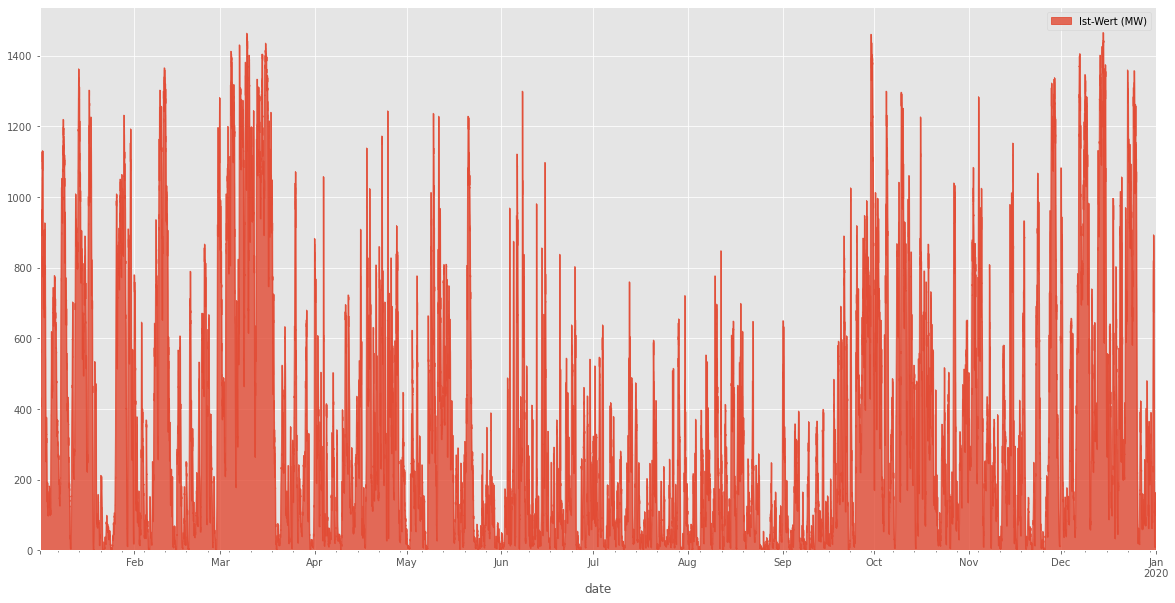

In [8]:
dfWind.plot.area(x="date",y="Ist-Wert (MW)",figsize=(20,10),lw=1,alpha = 0.8)

In [9]:
df_oneYear = pd.DataFrame(columns=["date","solar", "wind", "total"])
df_oneYear["date"] = dfWind["date"]
df_oneYear["solar"] = dfSolar["Ist-Wert (MW)"]
df_oneYear["wind"] = dfWind["Ist-Wert (MW)"]
df_oneYear.reset_index(inplace=True,drop=True)

In [10]:
#scale solar output to 151200MWh per year
df_oneYear["solar"] = df_oneYear["solar"]/148.21911375661375

#scale wind output to 50000MWh per year
df_oneYear["wind"] = df_oneYear["wind"]/247.99444

df_oneYear["total"] = df_oneYear["solar"] + df_oneYear["wind"]

In [11]:
sum(df_oneYear["total"])

201199.99999999985

In [12]:
def specifyLoad(row):
    if(row["date_x"].dayofweek<5):
       # if(row["date_x"].dayofweek==0 and row["date_y"] == "00:00:00"):
       #     return row["sunday"]
        return row["workday"]
    elif(row["date_x"].dayofweek==5):
       # if(row["date_y"] == "00:00:00"):
       #     return row["workday"]
        return row["saturday"]
    elif(row["date_x"].dayofweek==6):
        #if(row["date_y"] == "00:00:00"):
        #    return row["work"]
        return row["sunday"]

In [13]:
#Dynamisierungsfaktor F
def dynamismFactor(t):
    return (-3.92*10**-10)*t**4 + (3.2*10**-7)*t**3 - (7.02*10**-5)*t**2 + (2.1*10**-3)*t + 1.24

def dynamise(df):
    for i in range(len(df)):
        df["load"][i] = df["load"][i]*dynamismFactor(df["date"][i])

In [14]:
#change path to data folder
winterH0 = pd.read_csv(r'C:\Users\Janwe\OneDrive\Desktop\Bachelor_Arbeit\Direct Load Control Model\Data\H0_winter.csv')

In [15]:
h0_winter = pd.DataFrame(columns=["date","load"])

start = datetime.datetime(2019,1,1,0,15,0)
end = datetime.datetime(2019,3,20,0,0,0)

h0_winter["date"] = dateTimeList(start,end)

res = -1
ind =[]

for i in h0_winter.iterrows():
    if(res == 95):
        res=-1
    res += 1
    ind.append(res)

        
h0_winter["Id"] = ind
winterH0.index.name = "Id"
h0_winter = h0_winter.merge(winterH0, how='left',on="Id")

h0_winter["load"] = h0_winter.apply(lambda row: specifyLoad(row),axis=1)

h0_winter.rename(columns={"date_x" : "date"},inplace=True)
h0_winter = h0_winter[["date","load"]]

In [16]:
h0_winter["load"] = h0_winter.apply(lambda row: row["load"]*dynamismFactor(row["date"].dayofyear),axis = 1)

In [17]:
h0_winter2 = pd.DataFrame(columns=["date","load"])

start = datetime.datetime(2019,12,1,0,15,0)
end = datetime.datetime(2020,1,1,0,0,0)

h0_winter2["date"] = dateTimeList(start,end)

res = -1
ind =[]

for i in h0_winter2.iterrows():
    if(res == 95):
        res=-1
    res += 1
    ind.append(res)

        
h0_winter2["Id"] = ind
winterH0.index.name = "Id"
h0_winter2 = h0_winter2.merge(winterH0, how='left',on="Id")

h0_winter2["load"] = h0_winter2.apply(lambda row: specifyLoad(row),axis=1)
h0_winter2.rename(columns={"date_x" : "date"},inplace=True)
h0_winter2 = h0_winter2[["date","load"]]

In [18]:
h0_winter2["load"] = h0_winter2.apply(lambda row: row["load"]*dynamismFactor(row["date"].dayofyear),axis = 1)

In [19]:
#change path to data folder
summerH0 = pd.read_csv(r'C:\Users\Janwe\OneDrive\Desktop\Bachelor_Arbeit\Direct Load Control Model\Data\H0_summer.csv')

h0_summer = pd.DataFrame(columns=["date","load"])
start = datetime.datetime(2019,6,1,0,15,0)
end = datetime.datetime(2019,9,1,0,0,0)

h0_summer["date"] = dateTimeList(start,end)

res = -1
ind =[]

for i in h0_summer.iterrows():
    if(res == 95):
        res=-1
    res += 1
    ind.append(res)
    
h0_summer["Id"] = ind
summerH0.index.name = "Id"
h0_summer = h0_summer.merge(summerH0, how='left',on="Id")
h0_summer["load"] = h0_summer.apply(lambda row: specifyLoad(row),axis=1)
h0_summer.rename(columns={"date_x" : "date"},inplace=True)
h0_summer = h0_summer[["date","load"]]

In [20]:
h0_summer["load"] = h0_summer.apply(lambda row: row["load"]*dynamismFactor(row["date"].dayofyear),axis = 1)

In [21]:
transitionH0 = pd.read_csv(r'C:\Users\Janwe\OneDrive\Desktop\Bachelor_Arbeit\Direct Load Control Model\Data\H0_transition.csv')

h0_transition = pd.DataFrame(columns=["date","load"])
start = datetime.datetime(2019,3,20,0,15,0)
end = datetime.datetime(2019,6,1,0,0,0)

h0_transition["date"] = dateTimeList(start,end)

res = -1
ind =[]

for i in h0_transition.iterrows():
    if(res == 95):
        res=-1
    res += 1
    ind.append(res)

h0_transition["Id"] = ind
transitionH0.index.name = "Id"
h0_transition = h0_transition.merge(transitionH0, how='left',on="Id")
h0_transition["load"] = h0_transition.apply(lambda row: specifyLoad(row),axis=1)
h0_transition.rename(columns={"date_x" : "date"},inplace=True)
h0_transition = h0_transition[["date","load"]]

In [22]:
h0_transition["load"] = h0_transition.apply(lambda row: row["load"]*dynamismFactor(row["date"].dayofyear),axis = 1)

In [23]:
h0_transition2 = pd.DataFrame(columns=["date","load"])
start = datetime.datetime(2019,9,1,0,15,0)
end = datetime.datetime(2019,12,1,0,0,0)

h0_transition2["date"] = dateTimeList(start,end)

res = -1
ind =[]

for i in h0_transition2.iterrows():
    if(res == 95):
        res=-1
    res += 1
    ind.append(res)
    
h0_transition2["Id"] = ind
transitionH0.index.name = "Id"
h0_transition2 = h0_transition2.merge(transitionH0, how='left',on="Id")
h0_transition2["load"] = h0_transition2.apply(lambda row: specifyLoad(row),axis=1)
h0_transition2.rename(columns={"date_x" : "date"},inplace=True)
h0_transition2 = h0_transition2[["date","load"]]

In [24]:
h0_transition2["load"] = h0_transition2.apply(lambda row: row["load"]*dynamismFactor(row["date"].dayofyear),axis = 1)

In [25]:
h0_2019 = pd.concat([h0_winter,h0_transition, h0_summer,h0_transition2,h0_winter2]).reset_index(drop=True)
dfTotal_2019_65000H = df_oneYear.merge(h0_2019,on="date",how="outer").sort_values(by="date")

In [26]:
#scale Wh to kWh
dfTotal_2019_65000H["load"] = dfTotal_2019_65000H["load"]/1000

#scale sum of load to 2801
dfTotal_2019_65000H["load"] = dfTotal_2019_65000H["load"]/1.42650061

#scale kWh to MWh
dfTotal_2019_65000H["load"] = dfTotal_2019_65000H["load"]/1000

#scale to 65000 households
dfTotal_2019_65000H["load"] = dfTotal_2019_65000H["load"]*65000

In [27]:
sum(dfTotal_2019_65000H["total"])

201199.99999999985